In [1]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
from onsager import crystal, cluster, supercell
from SymmLayers import GCNet

# Load Crystal data

In [3]:
# Read crystal data
crysType = "BCC"
CrysDatPath = "../CrysDat_"+crysType+"/"

# Load symmetry operations with which they were constructed
with open(CrysDatPath + "GroupOpsIndices.pkl", "rb") as fl:
    GIndtoGDict = pickle.load(fl)

dxNN = np.load(CrysDatPath + "nnJumpLatVecs.npy")
RtoSiteInd = np.load(CrysDatPath + "RtoSiteInd.npy")
SiteIndtoR = np.load(CrysDatPath + "SiteIndtoR.npy")
GpermNNIdx = np.load(CrysDatPath + "GroupNNpermutations.npy")
siteShellIndices = np.load(CrysDatPath + "SitesToShells.npy")

NNsiteList = np.load(CrysDatPath + "NNsites_sitewise.npy")
dxList = np.load(CrysDatPath + "dxList.npy")

norm = np.linalg.norm(dxList[0])

dxList /= norm

N_ngb = NNsiteList.shape[0]
Nsites = NNsiteList.shape[1]

with open(CrysDatPath + "supercell"+crysType+".pkl", "rb") as fl:
    superBCC = pickle.load(fl)

In [5]:
# Make a batch of states that are related by symmetry
NspCh = 2
TestStates = np.random.randint(0, 2, (len(GpermNNIdx), NspCh, Nsites))
for gInd, g in GIndtoGDict.items():
    for siteInd in range(Nsites):
        _, RSite = superBCC.ciR(siteInd)
        Rnew, _ = superBCC.crys.g_pos(g, RSite, (0,0))
        Rnew %= 8
        siteIndNew = RtoSiteInd[Rnew[0], Rnew[1], Rnew[2]]
        TestStates[gInd, :, siteIndNew] = TestStates[0, :, siteInd]

## Next we make symmetry parameters

In [6]:
GnnPerms = pt.tensor(GpermNNIdx).long()
NNsites = pt.tensor(NNsiteList).long()
JumpUnitVecs = pt.tensor(dxList.T)
Ng = GnnPerms.shape[0]
Ndim = 3

# Now let's build the network

In [9]:
Nbatch = TestStates.shape[0]
# Let's predict 5 channels of vectors
gNet = GCNet(GnnPerms.long(), NNsites, JumpUnitVecs, dim=3, N_ngb=N_ngb,
             NSpec=NspCh, mean=0.05, std=0.01, nl=3, nch=8, nchLast=5).double()
StateTensors = pt.tensor(TestStates).double()
StateTensors.shape

torch.Size([48, 2, 512])

In [10]:
with pt.no_grad():
    y=gNet(StateTensors)

In [11]:
y_np = y.data.numpy().copy()
# y_np = y_np[:, 0, :, :]
y_np.shape

(48, 5, 3, 512)

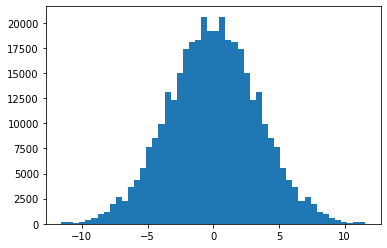

In [12]:
# Check that y vectors are not too small so as to have meaningful tests
_, _, _ = plt.hist(y_np.flatten(), bins=50)

In [13]:
# Check that subsequent y vectors are related by symmetry
y0 = y_np[0].copy()
for gInd, g in GIndtoGDict.items():
    for site in range(512):
        Rsite = SiteIndtoR[site]
        RsiteNew, _ = superBCC.crys.g_pos(g, Rsite, (0, 0))
        RsiteNew = RsiteNew % 8 # bring back into supercell
        siteNew = RtoSiteInd[RsiteNew[0], RsiteNew[1], RsiteNew[2]]
        for ch in range(y0.shape[0]):
            assert np.allclose(np.dot(g.cartrot, y0[ch, :, site]), y_np[gInd, ch, :, siteNew])
        
print("Vector Layer Symmetry assertions passed")

Vector Layer Symmetry assertions passed


In [14]:
# Check the y vectors explicitly
with pt.no_grad():
    out = gNet.net(StateTensors)
    for stateInd in tqdm(range(out.shape[0])):
        for channel in range(out.shape[1]):
            for site in range(Nsites):
                a_site = out[stateInd, channel, NNsites[1:, site]]
                siteVec = sum(a_site[i]*JumpUnitVecs[:, i] for i in range(N_ngb -1)).detach().numpy()
                assert np.allclose(siteVec, y_np[stateInd, channel, :, site])

100%|███████████████████████████████████████████| 48/48 [00:38<00:00,  1.25it/s]


In [15]:
def checkSymLayer(out, Nch):
    for ch in range(Nch):
        outsamp0 = out[0, ch, :]
        for gInd, g in GIndtoGDict.items():
            outsamp = pt.zeros_like(outsamp0)
            for siteInd in range(512):
                RSite = SiteIndtoR[siteInd]
                Rnew, _ = superBCC.crys.g_pos(g, RSite, (0,0))
                Rnew %= 8
                siteIndNew = RtoSiteInd[Rnew[0], Rnew[1], Rnew[2]]
                outsamp[siteIndNew] = outsamp0[siteInd]
            assert pt.allclose(outsamp, out[gInd, ch, :], atol=1e-12)

In [16]:
len(gNet.net)

15

In [17]:
# Check symmetries of internal layers:
out = pt.clone(StateTensors)
with pt.no_grad():
    for l in range(0, len(gNet.net), 3):
        assert out.shape[1]==gNet.net[l].Psi.shape[1]
        out = gNet.net[l].forward(out)
        out = gNet.net[l+1].forward(out)
        out = gNet.net[l+2].forward(out)
        Nch = out.shape[1]
        assert Nch==gNet.net[l].Psi.shape[0]
        checkSymLayer(out, Nch)
        print("Layer {} symmetry assertion passed".format((l + 3)//3))

Layer 1 symmetry assertion passed
Layer 2 symmetry assertion passed
Layer 3 symmetry assertion passed
Layer 4 symmetry assertion passed
Layer 5 symmetry assertion passed


In [41]:
# Do a layer convolution explicitly and check value
with pt.no_grad():
    l = 0
    outl_Gconv = gNet.net[l].forward(StateTensors)
    for stateInd in tqdm(range(2), ncols=65, position=0, leave=True):
        for chOut in range(gNet.net[l].Psi.shape[0]):
            b = gNet.net[l].bias[chOut]
            for site in range(Nsites):
                sitesNgb = NNsites[:, site]
                lm_sum = 0.
                for gInd in range(GnnPerms.shape[0]):
                    sm = 0.
                    for chIn in range(gNet.net[l].Psi.shape[1]):
                        Psi_g = gNet.net[l].Psi[chOut, chIn][GnnPerms[gInd]]
                        siteConv = pt.sum(Psi_g * StateTensors[stateInd, chIn, sitesNgb])
                        sm += siteConv
                    assert pt.allclose(outl_Gconv[stateInd, chOut, gInd, site], sm + b)
    print("Gconv explicit test passed")

100%|██████████████████████████████| 2/2 [01:35<00:00, 47.81s/it]

Gconv explicit test passed


In [43]:
# Use the following for counting parameters
gNet = GCNet(GnnPerms.long(), NNsites, JumpUnitVecs, dim=3, N_ngb=N_ngb,
             NSpec=5, mean=0.05, std=0.01, nl=3, nch=8, nchLast=12).double()

sm = 0
for layer in range(0, len(gNet.net), 3):
    sm += gNet.net[layer].Psi.shape[0] * gNet.net[layer].Psi.shape[1] * gNet.net[layer].Psi.shape[2]
    sm += gNet.net[layer].bias.shape[0]
sm

2996